DEA

In [21]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [25]:
# Load CSV file
file_path = (r"C:\Users\levyg\OneDrive\Desktop\Engenharia\Mestrado\Mestrado\Pesquisa Operacional\Mestrado_Pesquisa_Operacional_case_DEA\DEA case 1.6.4.csv")
df = pd.read_csv(file_path, sep=';')

In [26]:
df

,DMU,Real estate,Wages,Economics graduates,Business graduates,Math graduates
0,1,72,81,77,73,78
1,2,73,82,73,70,69
2,3,70,59,72,67,80
3,4,87,83,69,74,84
4,5,53,64,57,65,65
5,6,71,85,78,72,73
6,7,65,68,81,71,69
7,8,59,62,64,66,56
8,9,134,186,150,168,172
9,10,134,140,134,130,130


In [27]:
# Define DMUs, inputs, and outputs
DMUs = df['DMU'].tolist()
inputs = df[['Real estate', 'Wages']].values
outputs = df[['Economics graduates','Business graduates', 'Math graduates']].values


CRS

In [30]:
# Function to perform DEA CRS
def dea_crs(inputs, outputs, DMUs):
    num_dmus = len(DMUs)
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]
    
    results = []
    
    for dmu in range(num_dmus):
        # Create the problem
        prob = pulp.LpProblem(f"DEA_CRS_DMU_{DMUs[dmu]}", pulp.LpMaximize)
        
        # Define decision variables (weights for inputs and outputs)
        u = pulp.LpVariable.dicts("u", range(num_outputs), lowBound=0)
        v = pulp.LpVariable.dicts("v", range(num_inputs), lowBound=0)
        
        # Objective function: maximize the efficiency of the DMU
        prob += pulp.lpSum([u[j] * outputs[dmu][j] for j in range(num_outputs)])
        
        # Constraints: efficiency of all DMUs should be <= 1
        for i in range(num_dmus):
            prob += pulp.lpSum([u[j] * outputs[i][j] for j in range(num_outputs)]) - \
                    pulp.lpSum([v[k] * inputs[i][k] for k in range(num_inputs)]) <= 0
        
        # Normalization constraint: sum of input weights = 1
        prob += pulp.lpSum([v[k] * inputs[dmu][k] for k in range(num_inputs)]) == 1
        
        # Solve the problem
        prob.solve()
        
        # Extract results
        efficiency = pulp.value(prob.objective)
        u_values = [pulp.value(u[j]) for j in range(num_outputs)]
        v_values = [pulp.value(v[k]) for k in range(num_inputs)]
        
        # Calculate weighted inputs and outputs
        weighted_inputs = sum([v_values[k] * inputs[dmu][k] for k in range(num_inputs)])
        weighted_outputs = sum([u_values[j] * outputs[dmu][j] for j in range(num_outputs)])
        
        results.append({
            'DMU': DMUs[dmu],
            'weight_Real_estate': v_values[0],
            'weight_Wages': v_values[1],
            'weight_Economics_graduates': u_values[0],
            'weight_Business_graduates': u_values[0],
            'weight_math_graduates': u_values[0],
            'efficiency': efficiency
        })
    
    # Convert results to DataFrame
    df_crs = pd.DataFrame(results)
    
    # Add ranking column (1 = most efficient, higher numbers = less efficient)
    df_crs['Ranking'] = df_crs['efficiency'].rank(ascending=False, method='min').astype(int)
    

    
    return df_crs

# Run DEA CRS
df_crs = dea_crs(inputs, outputs, DMUs)

# Save results to CSV
df_crs.to_csv('dea_crs_results.csv', index=False)

print("DEA CRS Results with Ranking:")
df_crs

DEA CRS Results with Ranking:


,DMU,weight_Real_estate,weight_Wages,weight_Economics_graduates,weight_Business_graduates,weight_math_graduates,efficiency,Ranking
0,1,0.010923,0.002636,0.005060,0.005060,0.005060,0.931558,6
1,2,0.010126,0.003180,0.004160,0.004160,0.004160,0.839469,9
2,3,0.000000,0.016949,0.000000,0.000000,0.000000,1.000000,2
3,4,0.008683,0.002947,0.000000,0.000000,0.000000,0.825480,10
4,5,0.016057,0.002328,0.000000,0.000000,0.000000,1.000000,5
5,6,0.014085,0.000000,0.007605,0.007605,0.007605,0.910043,7
6,7,0.015385,0.000000,0.012346,0.012346,0.012346,1.000000,3
7,8,0.005999,0.010421,0.000000,0.000000,0.000000,1.000000,4
8,9,0.007463,0.000000,0.000000,0.000000,0.000000,1.000000,1
9,10,0.002800,0.004462,0.000637,0.000637,0.000637,0.880773,8


VRS

In [31]:
# Function to perform DEA VRS
def dea_vrs(inputs, outputs, DMUs):
    num_dmus = len(DMUs)
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]
    
    results = []
    
    for dmu in range(num_dmus):
        # Create the problem
        prob = pulp.LpProblem(f"DEA_VRS_DMU_{DMUs[dmu]}", pulp.LpMaximize)
        
        # Define decision variables (weights for inputs and outputs)
        u = pulp.LpVariable.dicts("u", range(num_outputs), lowBound=0)
        v = pulp.LpVariable.dicts("v", range(num_inputs), lowBound=0)
        u0 = pulp.LpVariable("u0", cat='Continuous')  # Free variable for VRS
        
        # Objective function: maximize the efficiency of the DMU
        prob += pulp.lpSum([u[j] * outputs[dmu][j] for j in range(num_outputs)]) + u0
        
        # Constraints: efficiency of all DMUs should be <= 1
        for i in range(num_dmus):
            prob += pulp.lpSum([u[j] * outputs[i][j] for j in range(num_outputs)]) - \
                    pulp.lpSum([v[k] * inputs[i][k] for k in range(num_inputs)]) + u0 <= 0
        
        # Normalization constraint: sum of input weights = 1
        prob += pulp.lpSum([v[k] * inputs[dmu][k] for k in range(num_inputs)]) == 1
        
        # Solve the problem
        prob.solve()
        
        # Extract results
        efficiency = pulp.value(prob.objective)
        u_values = [pulp.value(u[j]) for j in range(num_outputs)]
        v_values = [pulp.value(v[k]) for k in range(num_inputs)]
        u0_value = pulp.value(u0)
        
        # Calculate weighted inputs and outputs
        weighted_inputs = sum([v_values[k] * inputs[dmu][k] for k in range(num_inputs)])
        weighted_outputs = sum([u_values[j] * outputs[dmu][j] for j in range(num_outputs)]) + u0_value
        
        results.append({
            'DMU': DMUs[dmu],
            'weight_Real_estate': v_values[0],
            'weight_Wages': v_values[1],
            'weight_Economics_graduates': u_values[0],
            'weight_Business_graduates': u_values[0],
            'weight_math_graduates': u_values[0],
            'efficiency': efficiency
        })
    
    # Convert results to DataFrame
    df_vrs = pd.DataFrame(results)
    
    # Add ranking column (1 = most efficient, higher numbers = less efficient)
    df_vrs['Ranking'] = df_vrs['efficiency'].rank(ascending=False, method='min').astype(int)
    

    
    return df_vrs

# Run DEA VRS
df_vrs = dea_vrs(inputs, outputs, DMUs)

# Save results to CSV
df_vrs.to_csv('dea_vrs_results.csv', index=False)

print("DEA VRS Results with Ranking:")
df_vrs

DEA VRS Results with Ranking:


,DMU,weight_Real_estate,weight_Wages,weight_Economics_graduates,weight_Business_graduates,weight_math_graduates,efficiency,Ranking
0,1,0.011163,0.002423,0.004814,0.004814,0.004814,0.934369,7
1,2,0.013699,0.000000,0.005988,0.005988,0.005988,0.842503,9
2,3,0.000000,0.016949,0.000000,0.000000,0.000000,1.000000,4
3,4,0.004045,0.007808,0.000000,0.000000,0.000000,0.829613,10
4,5,0.004082,0.012245,0.000000,0.000000,0.000000,1.000000,4
5,6,0.014085,0.000000,0.006157,0.006157,0.006157,0.918264,8
6,7,0.006232,0.008749,0.005287,0.005287,0.005287,1.000000,3
7,8,0.003492,0.012806,0.000000,0.000000,0.000000,1.000000,4
8,9,0.007463,0.000000,0.000000,0.000000,0.000000,1.000000,2
9,10,0.002502,0.004748,0.006628,0.006628,0.006628,1.000000,1


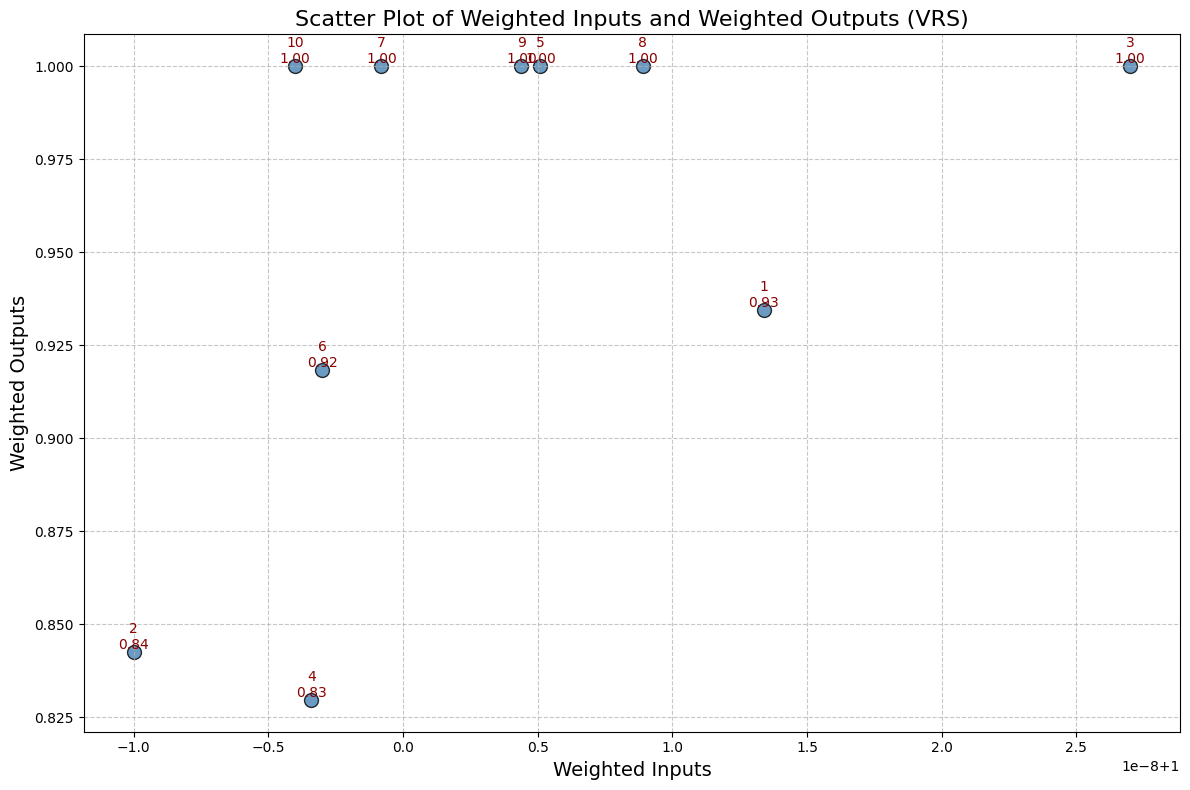

In [ ]:
# Plot the scatter plot
plt.figure(figsize=(12, 8))

# Create the scatter plot
plt.scatter(
    df_vrs['inputs_weighted'],  # Weighted Inputs on the X-axis
    df_vrs['outputs_weighted'],  # Weighted Outputs on the Y-axis
    s=100,  # Size of the points
    alpha=0.8,  # Transparency of the points
    color='steelblue',  # Color of the points
    edgecolors='k'  # Outline of the points
)

# Add data labels (DMU and Efficiency)
for i in range(len(df_vrs)):
    dmu = df_vrs['DMU'].iloc[i]
    eficiencia = df_vrs['efficiency'].iloc[i]
    x = df_vrs['inputs_weighted'].iloc[i]
    y = df_vrs['outputs_weighted'].iloc[i]
    plt.text(
        x, y, 
        f'{dmu}\n{eficiencia:.2f}', 
        fontsize=10, ha='center', va='bottom', color='darkred'
    )

# Add labels and title
plt.title('Scatter Plot of Weighted Inputs and Weighted Outputs (VRS)', fontsize=16)
plt.xlabel('Weighted Inputs', fontsize=14)
plt.ylabel('Weighted Outputs', fontsize=14)

# Adjust grid for better visualization
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()